<a href="https://colab.research.google.com/github/Geebigib/Data-Science-Project/blob/main/COUTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !pip install torch==1.8.1+cpu torchvision==0.9.1+cpu torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install -r requirements.txt

In [3]:
!pip install GPUtil==1.4.0 torch==1.10.1 PyYAML~=5.1.2 tqdm==4.62.3 joblib~=1.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# !unzip /content/drive/MyDrive/SWaT_Dataset_v0.zip -d /content/

In [1]:
import numpy as np
import os
import pandas as pd
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import pickle
import tqdm

swat_normal = pd.read_csv("SWaT_Dataset_Normal_v0.csv", skiprows=1)
swat_attack = pd.read_csv("SWaT_Dataset_Attack_v0.csv")

In [2]:
swat_normal.columns = swat_normal.columns.str.replace(' ','')
swat_attack.columns = swat_attack.columns.str.replace(' ','')

In [3]:
swat_attack["Normal/Attack"].replace(' ', '', regex=True, inplace=True)

In [4]:
test_df = swat_attack.set_index('Timestamp')
test_df['label'] = np.where(test_df['Normal/Attack'] == 'Attack', 1, 0)
# test_df.apply(lambda x: 1 if test_df['Normal/Attack'] == 'Attack' else 0)
test_df = test_df.drop('Normal/Attack', axis=1)
assert test_df.shape == (449919, 52)

# train_df = train_df.drop(columns=['Unnamed: 0', 'Unnamed: 52'])
train_df = swat_normal.set_index('Timestamp')
train_df['label'] = np.where(train_df['Normal/Attack'] == 'Attack', 1, 0)
train_df = train_df.drop('Normal/Attack', axis=1)

# following [Zhihan Li et al. KDD21] & [Dan Li. ICANN. 2019]
# fow SWaT data, due to the cold start of the system, starting point is 21600
train_df = train_df.iloc[21600:]


clone repository

In [10]:
!git init
!git remote add origin https://github.com/xuhongzuo/couta.git 
!git pull origin main

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/xuhongzuo/couta
 * branch            main       -> FETCH_HEAD
Already up to date.


In [5]:
output_dir = 'data_processed_contam/SWaT/'
os.makedirs(output_dir, exist_ok=True)
train_df.to_csv(os.path.join(output_dir, 'SWaT_train.csv'))
test_df.to_csv(os.path.join(output_dir, 'SWaT_test.csv'))

In [6]:
#import pre-trained model
from src.algorithms.couta_algo import COUTA
# sequence_length = 100, out of memory!!
model_configs = {'sequence_length': 50, 'stride': 1, 'num_epochs': 20 }
model = COUTA(**model_configs)

{'sequence_length': 50, 'stride': 1, 'num_epochs': 20, 'batch_size': 64, 'lr': 0.0001, 'ss_type': 'FULL', 'hidden_dims': 16, 'emb_dim': 16, 'rep_hidden': 16, 'pretext_hidden': 16, 'kernel_size': 2, 'dropout': 0.0, 'bias': True, 'alpha': 0.1, 'neg_batch_ratio': 0.2, 'es': False, 'train_val_pc': 0.25, 'seed': 0, 'model_dir': 'couta_model/', 'nac': True, 'umc': True}


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
train_df.drop(columns = 'label',inplace = True)
label = test_df['label'].values
test_df.drop(columns = 'label',inplace = True)

In [8]:
#normalise data
scaler = MinMaxScaler()
scaler = scaler.fit(train_df)

In [9]:
train_scale = pd.DataFrame(
    scaler.transform(train_df),
    index = train_df.index,
    columns= train_df.columns
)

test_scale  = pd.DataFrame(
    scaler.transform(test_df),
    index = test_df.index,
    columns= test_df.columns
)

In [ ]:
model.fit(train_scale)

beginning convert sequence 50
convert to sequences: sequences[0].shape (50, 51)
convert to sequences:  len(sequences) 475151


In [20]:
score = model.predict(test_scale)

In [ ]:
# from main_utils import run
# predictions, eval_metrics, adj_eval_metrics = run(train_df, test_df, label, model, data_name='SWaT-SWaT')

In [21]:
from src.utils_eval import get_metrics, adjust_scores

In [22]:
eval_info = get_metrics(label, score)
adj_eval_metrics = get_metrics(label, adjust_scores(label, score))

In [23]:
entries = []
entries.append(adj_eval_metrics)
avg_entry = np.average(np.array(entries), axis=0)
std_entry = np.std(np.array(entries), axis=0)

In [24]:
f1_lst = avg_entry[2]
aupr_lst = avg_entry[1]

In [25]:
f1_lst,aupr_lst

(0.8480309964555064, 0.8197033889494084)

In [26]:
from src.utils_general import plt_res_with_dat 

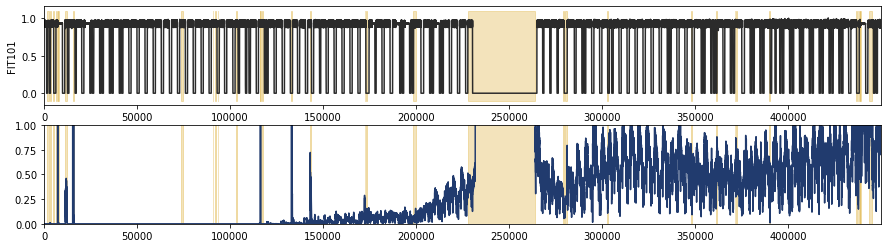

In [28]:
fig = plt_res_with_dat([score],label,test_df['FIT101'])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(label,  score)
auc = metrics.roc_auc_score(label,  score)

In [ ]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Finding error score threshold

In [ ]:
!pip install ghostml

In [ ]:
import ghostml

def calc_metrics(labels_test, test_probs, threshold = 0.5):
    scores = [1 if x>=threshold else 0 for x in test_probs]
    auc = metrics.roc_auc_score(labels_test, test_probs)
    kappa = metrics.cohen_kappa_score(labels_test,scores)
    confusion = metrics.confusion_matrix(labels_test,scores, labels=list(set(labels_test)))
    print('thresh: %.2f, kappa: %.3f, AUC test-set: %.3f'%(threshold, kappa, auc))
    print(confusion)
    print(metrics.classification_report(labels_test,scores))
    return 

In [ ]:
thresholds = np.arange(0.05,max(score),0.05)
threshold1 = ghostml.optimize_threshold_from_predictions(label, score, thresholds, ThOpt_metrics = 'Kappa') 

# Print confusion matrix and classification metrics
calc_metrics(label, score, threshold = threshold1)

In [ ]:
# %debug

Apply XAI

In [ ]:
!pip install shap

In [ ]:
!pip install omnixai

In [ ]:
import shap